# Walkthrough Tutorial of Mitochondrial Motility Code

This notebook is meant as a starting point for an interested reader to familiarize themselves with the code used in our paper [Activity-dependent regulation of mitochondrial motility in developing cortical dendrites](https://elifesciences.org/articles/62091). 

This notebook touches on the main points of interest in this code used to model stopping times of mitochondria in response to synaptic activity. In particular, we show the functions used to generate:

- Spike train data drawn at different frequencies (visualized with raster plots)
- Populations of mitochondria with unique stopping & recovery times drawn from a normal distribution (visualized by histograms of stopping times for the given population of mitochondria and lineplots of the percentage of motile mitochondria during the period of synaptic activity)
- Dose response curves to determine which paradigm most closely parallels the behaviour of mitochondria observed experimentally 

In [1]:
# import necessary packages 
import numpy as np 
from elephant.spike_train_generation import homogeneous_poisson_process
from quantities import Hz, s, ms

import functions as F
import plotting as pt


In [2]:
# set parameters -- for experimentation default parameters are set in util.py
dend_L      = 70
event_range = [1,2]                                 # um affected by synaptic events
event_min   = event_range[0]/dend_L                 # min percentage of dendrite affected by synaptic event
event_max   = event_range[1]/dend_L                 # max percentage of dendrite affected by synaptic event
event_mean  = event_min + (event_max - event_min)/2 # mean percentage of dendrite affected by synaptic event
event_sd    = (event_max - event_mean)/3   

density     = 1/4
mito_pop    = 500
MM_pct_init = 1

days        = 5
day_seconds = 1500 

event_hz    = [0.001, 0.012, 0.035, 0.058, 0.081, 0.104, 0.127, 0.15, 0.25, 0.35, 0.5]
recov_means = np.array([1,2,3,4,5,6,7,8,9,10,15,20,25])*60 # avg number of seconds for mito to recover motility
recov_sd    = 2.5*60

params_dict = {
    'days':        days,         # number of distinct blocks of stimulation events
    'day_seconds': day_seconds,  # number of seconds per block of stimulation events 
    'density':     density,      # density of mitochondria (number/um)
    'dend_L':      dend_L,       # length of dendrite (um)
    'event_range': event_range,  # um affected by synaptic events
    'event_min':   event_min,    # min percentage of dendrite affected by synaptic event
    'event_max':   event_max,    # max percentage of dendrite affected by synaptic event
    'event_mean':  event_mean,   # mean percentage of dendrite affected by synaptic event
    'event_sd':    event_sd,     # 99% of distr covered by 3sd
    'mito_pop':    mito_pop,     # number of mitochondria in population
    'MM_pct_init': MM_pct_init,  # proportion of mobile mitochondria at t = 0
    'recov_means': recov_means,  # Mean of recovery times for normally distributed mitos
    'recov_sd':    recov_sd,     # standard deviation of recovery times for mitos
    'event_hz':    event_hz      # frequency of synaptic events
}

# params for simulations
num_runs = 10

## Example Spike Trains and Raster Plots

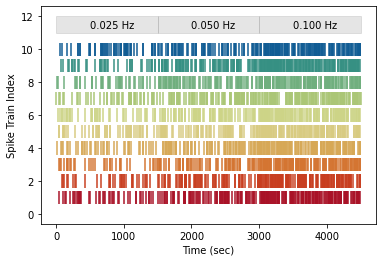

In [3]:
example_event_hz = [0.025, 0.05, 0.1]

spiketrain_list = F.get_spike_trains(num_runs, example_event_hz)
pt.plot_spike_raster(spiketrain_list, day_seconds, example_event_hz)

## Generating Population of Mitochondria

In [4]:
mito_pop   = params_dict['mito_pop'] # population =500 mitos
init_mob   = params_dict['MM_pct_init'] # proportion of mitos in mobile fraction at t=0

recov_mean = 120  # example avg number of seconds for mito to recover motility
recov_sd   = params_dict['recov_sd'] # sd of recovery time (experimental val = 2.5 min) in seconds 

mito_list = F.populate_list_n(mito_pop, init_mob, recov_mean, recov_sd) # list of mito objects

# at t=0, all mitos are mobile because no stimulation has occured yet to cause them to freeze
mobile_frac = F.calc_frac_mm(mito_list)
print(mobile_frac)

1.0


### Example Mitochondrial Stopping Times
Mito stopping times are an attribute of each instantiation of the `mitochondrion` class defined in `util.py`. For a given population of mitochondria, each member has its own stopping time. 

In the function `F.populate_list_n` the parameter `noisy_recovery` is by default True, which means mito stopping times are drawn from a normal distribution with $\mu=$ `recov_mean` and $\sigma=$ `recov_sd`. 

If `noisy_recovery` is False, all mitos have a stopping time of `recov_mean`. 

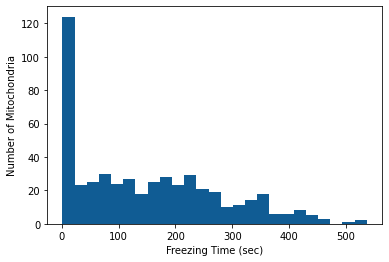

In [5]:
# show a histogram for stopping times of mitos in the mito_list
pt.plot_mito_hist(mito_list,n_bins=25)

### Example Mitochondrial Recovery Times

## Variation on Mean Stopping Times in Response to Differential Spike Frequency